In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import scipy.stats as stats
import seaborn as sns

import copy

C:\Users\ayxan\AppData\Local\Temp\ipykernel_24700\1653616882.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# data import  and normalization

In [105]:
data=pd.read_csv('processed.cleveland.data',sep=',',header=None)

data.columns=['age','sex','cp','trestbps','chol','fbs',\
              'rectecg','thalach','exang','oldpeak',\
              'slope','ca','thal','num']

data=data.replace('?',np.nan).dropna()

cols2zscore=data.keys()
cols2zscore=cols2zscore.drop(['sex','cp','fbs','exang','num'])

for c in cols2zscore:
    d=pd.to_numeric(data[c])
    data[c]=(d-d.mean())/d.std(ddof=1)
    
data_col=data.keys()
data_col=data_col.drop('num')

data['disease']=0
data['disease']=(data['num']>0).astype(int)

input_data=data[data_col]
disease=data['disease']

# input_data=np.concatenate((input_data,input_data),axis=0)
# disease=np.concatenate((disease,disease),axis=0)

# data preparing

In [110]:
train_data_tensor=torch.tensor(input_data.values).float()
disease_tensor=torch.tensor(disease.values).float()
disease_tensor=disease_tensor[:,None]
train_data,devtest_data,train_label,devtest_label=train_test_split(\
                                train_data_tensor,disease_tensor,train_size=.8)

test_data,dev_data,test_label,dev_label=train_test_split(\
                                                         devtest_data,devtest_label,train_size=0.5)

# train_data=torch.cat((train_data,train_data),axis=0)
# train_label=torch.cat((train_label,train_label),axis=0)

train_dataset=TensorDataset(train_data,train_label)
dev_dataset=TensorDataset(dev_data,dev_label)
test_dataset=TensorDataset(test_data,test_label)

output={}
output['train_loader']=DataLoader(train_dataset,batch_size=16,shuffle=True,drop_last=True)
output['dev_loader']=DataLoader(dev_dataset,batch_size=dev_dataset.tensors[0].shape[0])
output['test_loader']=DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])


# ann model 

In [113]:
def createModel():
    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input=nn.Linear(13,64)
            
            self.fc1=nn.Linear(64,64)
            self.bnorm1=nn.BatchNorm1d(64)
            
            self.fc2=nn.Linear(64,8)
            self.bnorm2=nn.BatchNorm1d(64)
            
            self.output=nn.Linear(8,1)
        def forward(self,x):
            x=F.relu(self.input(x))
            
            x=self.bnorm1(x)
            x=F.relu(self.fc1(x))
            
            x=self.bnorm2(x)
            x=F.relu(self.fc2(x))
            
            return self.output(x)
    
    ANN=Model()
    
    lossfun=nn.BCEWithLogitsLoss()
    
    optimizer=torch.optim.Adam(ANN.parameters(),lr=0.0001)
    
    return ANN,lossfun,optimizer

# model training

In [11]:
device=torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
print(device)

cuda:0


In [18]:
def trainModel(numEpoch=100):
    losses=torch.zeros(numEpoch)
    trainAcc=[]
    devAcc=[]
    
    ANN,lossfun,optimizer=createModel()
    
    bestModel={'accuracy':0,'model':None}
    
    ANN=ANN.to(device)
    
    for epoch in range(numEpoch):
        batchAcc=[]
        batchLoss=[]
        
        ANN.train()
        for dat,lab in output['train_loader']:
            dat=dat.to(device)
            lab=lab.to(device)
            
            yHat=ANN(dat)
            loss=lossfun(yHat,lab)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            lab=lab.cpu()
            yHat=yHat.cpu()
            
            batchLoss.append(loss.item())
            
            match=((yHat>0)==lab).float()
            batchAcc.append(100*torch.mean(match).item())
            
        trainAcc.append(np.mean(batchAcc))
        losses[epoch]=np.mean(batchLoss)
        
        ANN.eval()
        dat,lab=next(iter(output['dev_loader']))
        
        dat=dat.to(device)
        with torch.no_grad():
            yHat=ANN(dat)
            
        yHat=yHat.cpu()
        match=((yHat>0)==lab).float()
        devAcc.append(100*torch.mean(match).item())
        
        if bestModel['accuracy']<devAcc[-1]:
            bestModel['accuracy']=devAcc[-1]
            bestModel['model']=copy.deepcopy(ANN.state_dict())
            
    return bestModel,trainAcc,devAcc,losses

Text(0.5, 1.0, 'the last loss:0.31749990582466125')

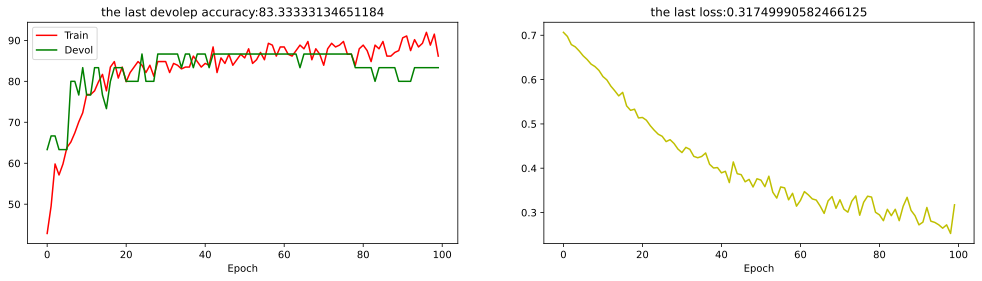

In [114]:
bestModel,trainAcc,devAcc,losses=trainModel(100)

fig,ax=plt.subplots(1,2,figsize=(17,4))
ax[0].plot(trainAcc,'r',label='Train')
ax[0].plot(devAcc,'g',label='Devol')
ax[0].set_xlabel('Epoch')
ax[0].set_title(f'the last devolep accuracy:{devAcc[-1]}')
ax[0].legend()

ax[1].plot(losses,'y')
ax[1].set_xlabel('Epoch')
ax[1].set_title(f'the last loss:{losses[-1]}')

In [115]:
dat,lab=next(iter(output['dev_loader']))
Heart_ann=createModel()[0]
Heart_ann.load_state_dict(bestModel['model'])

prediction=Heart_ann(dat)
accuracy=((prediction>0)==lab).float()
acc=100*torch.mean(accuracy)
acc

tensor(83.3333)

Text(1, 0, 'False positives:\n5')

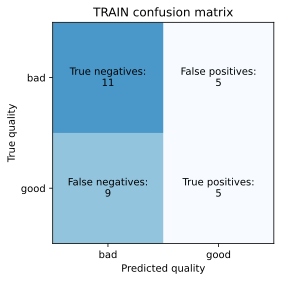

In [116]:
import sklearn.metrics as skm

testconf=skm.confusion_matrix(output['test_loader'].dataset.tensors[1],\
                             prediction>0)

fig,ax = plt.subplots(1,figsize=(10,4))

# confmat during TRAIN
ax.imshow(testconf,'Blues',vmax=len(prediction)/2)
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(['bad','good'])
ax.set_yticklabels(['bad','good'])
ax.set_xlabel('Predicted quality')
ax.set_ylabel('True quality')
ax.set_title('TRAIN confusion matrix')

ax.text(0,0,f'True negatives:\n{testconf[0,0]}' ,ha='center',va='center')
ax.text(0,1,f'False negatives:\n{testconf[1,0]}',ha='center',va='center')
ax.text(1,1,f'True positives:\n{testconf[1,1]}' ,ha='center',va='center')
ax.text(1,0,f'False positives:\n{testconf[0,1]}',ha='center',va='center')
